In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

In [2]:
# -------- SET PATHS --------
SIREN_DIR = '..\Dataset\Ambulance data'   # <-- Change this!
NOISE_DIR = '..\Dataset\Road Noises'  # <-- Change this!
SAMPLE_RATE = 48000
DURATION = 6
N_MFCC = 40


<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\karth\AppData\Local\Temp\ipykernel_10736\1682941479.py:2: SyntaxWarning: invalid escape sequence '\D'
  SIREN_DIR = '..\Dataset\Ambulance data'   # <-- Change this!
C:\Users\karth\AppData\Local\Temp\ipykernel_10736\1682941479.py:3: SyntaxWarning: invalid escape sequence '\D'
  NOISE_DIR = '..\Dataset\Road Noises'  # <-- Change this!


In [3]:

# -------- AUDIO DATA LOADING --------
def load_audio(dir_path, label):
    X, y = [], []
    n_samples = SAMPLE_RATE * DURATION
    files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]
    for fname in files:
        wav, _ = librosa.load(os.path.join(dir_path, fname), sr=SAMPLE_RATE)
        if len(wav) < n_samples:
            wav = np.pad(wav, (0, n_samples - len(wav)))
        else:
            wav = wav[:n_samples]
        X.append(wav)
        y.append(label)
    return X, y

X_siren, y_siren = load_audio(SIREN_DIR, 1)
X_noise, y_noise = load_audio(NOISE_DIR, 0)
X = np.array(X_siren + X_noise)
y = np.array(y_siren + y_noise)

e:\karthick\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [4]:
# -------- NEW FEATURE EXTRACTION --------
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION, res_type='kaiser_fast')
        pre_emphasis = 0.97
        emphasized_audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])

        mfccs = librosa.feature.mfcc(y=emphasized_audio, sr=sample_rate, n_mfcc=40)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_var = np.var(mfccs, axis=1)

        rms = librosa.feature.rms(y=audio).mean()

        feature_vector = np.hstack((mfccs_mean, mfccs_var, rms))
        return feature_vector
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# -------- LOAD DATA --------
file_paths = []
labels = []

# Load ambulance files (label 1)
for fname in os.listdir(SIREN_DIR):
    if fname.endswith(".wav"):
        file_paths.append(os.path.join(SIREN_DIR, fname))
        labels.append(1)

# Load noise files (label 0)
for fname in os.listdir(NOISE_DIR):
    if fname.endswith(".wav"):
        file_paths.append(os.path.join(NOISE_DIR, fname))
        labels.append(0)

# -------- EXTRACT FEATURES --------
X_feats = []
y_cleaned = []

for path, label in zip(file_paths, labels):
    feat = extract_features(path)
    if feat is not None:
        X_feats.append(feat)
        y_cleaned.append(label)

X_feats = np.array(X_feats)
y_cleaned = np.array(y_cleaned)

# -------- SCALE FEATURES --------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feats)

# -------- SPLIT DATA --------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned)

print("Features shape:", X_train.shape)
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Features shape: (1467, 81)
Training samples: 1467
Testing samples: 367


In [ ]:
# -------- BAYESIAN NN USING MC DROPOUT --------
def build_model(input_dim, dropout_rate=0.5):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(dropout_rate)(x, training=True)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x, training=True)

    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x, training=True)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

model = build_model(X_scaled.shape[1], dropout_rate=0.5)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=2)


Epoch 1/100
74/74 - 4s - 48ms/step - accuracy: 0.6573 - loss: 0.6416 - val_accuracy: 0.9286 - val_loss: 0.2896
Epoch 2/100
74/74 - 0s - 4ms/step - accuracy: 0.8363 - loss: 0.3834 - val_accuracy: 0.9388 - val_loss: 0.1708
Epoch 3/100
74/74 - 0s - 4ms/step - accuracy: 0.8900 - loss: 0.2835 - val_accuracy: 0.9490 - val_loss: 0.1285
Epoch 4/100
74/74 - 0s - 5ms/step - accuracy: 0.9130 - loss: 0.2449 - val_accuracy: 0.9694 - val_loss: 0.0994
Epoch 5/100
74/74 - 0s - 5ms/step - accuracy: 0.9292 - loss: 0.2223 - val_accuracy: 0.9728 - val_loss: 0.0983
Epoch 6/100
74/74 - 0s - 5ms/step - accuracy: 0.9301 - loss: 0.2211 - val_accuracy: 0.9728 - val_loss: 0.0804
Epoch 7/100
74/74 - 0s - 4ms/step - accuracy: 0.9335 - loss: 0.1901 - val_accuracy: 0.9762 - val_loss: 0.0725
Epoch 8/100
74/74 - 0s - 4ms/step - accuracy: 0.9344 - loss: 0.1845 - val_accuracy: 0.9762 - val_loss: 0.0746
Epoch 9/100
74/74 - 0s - 4ms/step - accuracy: 0.9429 - loss: 0.1732 - val_accuracy: 0.9762 - val_loss: 0.0683
Epoch 10/

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Sensitivity (Recall): 0.9840
Specificity:          0.9389
Accuracy:  0.9619
Precision: 0.9436
Recall:    0.9840
F1 Score:  0.9634
ROC AUC:   0.9773

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       180
           1       0.94      0.98      0.96       187

    accuracy                           0.96       367
   macro avg       0.96      0.96      0.96       367
weighted avg       0.96      0.96      0.96       367



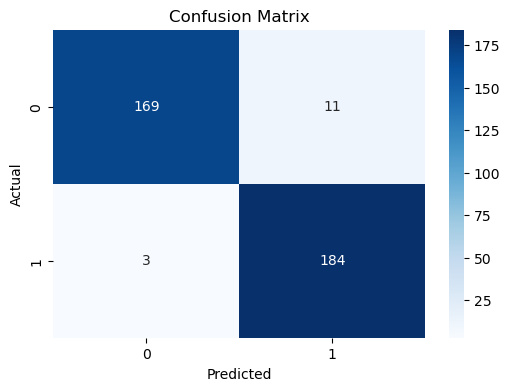

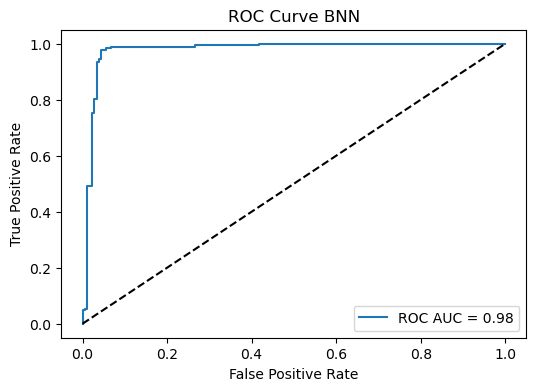

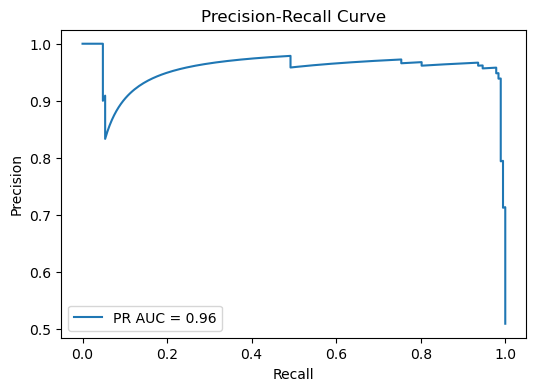

In [11]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)
import seaborn as sns

# Predict on test data
y_prob = model.predict(X_test).ravel()                # 1D array of predicted probabilities
y_pred = (y_prob > 0.5).astype(int)                   # Apply threshold to get binary predictions

# Compute metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)
# Compute Confusion Matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Sensitivity and Specificity
sensitivity = tp / (tp + fn)  # Same as recall
specificity = tn / (tn + fp)

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity:          {specificity:.4f}")

# Print metrics
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc_roc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc_roc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve BNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recalls, precisions)
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f"PR AUC = {pr_auc:.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


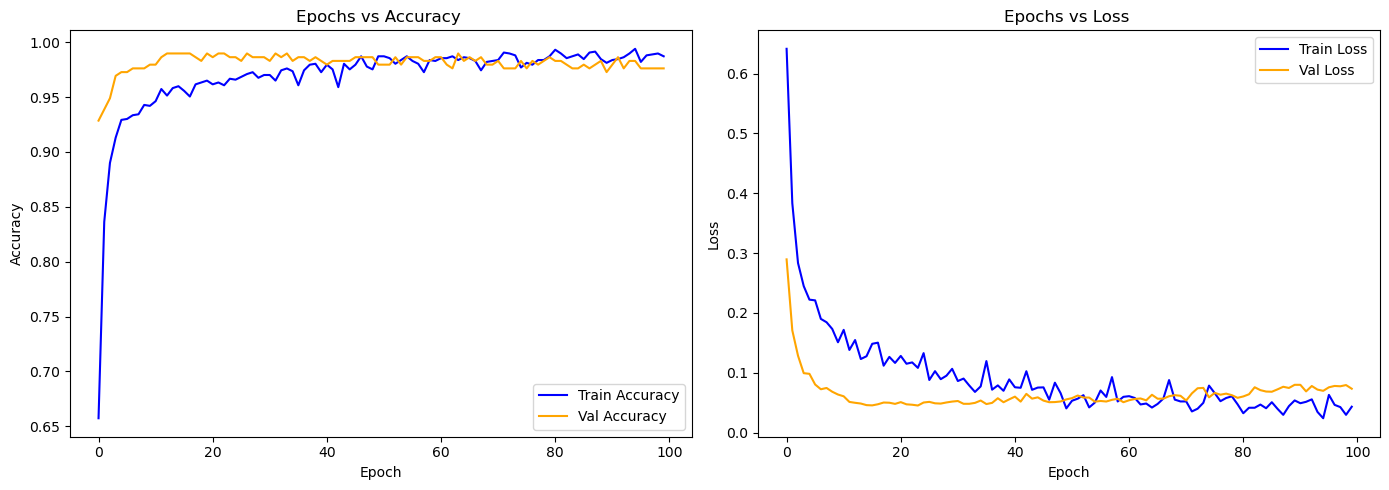

In [12]:
# -------- EPOCH VS METRICS PLOT --------


train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']



import matplotlib.pyplot as plt

epochs = range(len(train_acc))

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy', color='blue')
plt.plot(epochs, val_acc, label='Val Accuracy', color='orange')
plt.title('Epochs vs Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Val Loss', color='orange')
plt.title('Epochs vs Loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

